Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Hannah Lange"
COLLABORATORS = ""

---

In [2]:
import numpy as np
import operator
import matplotlib.pyplot as plt
from pprint import pprint
import seaborn as sns

%matplotlib inline

# GridWorld

We have two classes: one for the environment `GridWorld` and one for the agent `Agent`, which follows the Q-learning policy. The dimensions of the grid are 5x5, we have one pitfall at (1,3) and the exit is at (0,3). The Agent wins when it finds the exit (reward +10) and loses when it hits the pitfall (reward -10), in both cases the episode is terminated. Each step is punished by a negative reward of -1. Possible actions are UP, DOWN, RIGHT, LEFT. The gird stores all the rewards as given in the `__init__()`.

* Complete the `make_step` method in the `GridWorld` class, that moves the agent in a specified direction. If agent is at a border, agent stays still but takes negative reward.

* Write the functions `chose_action` and `learn` in the `Agent` class. Follow the instructions to implement Q-learning.



In [3]:
class GridWorld:
    ## Initialise starting data
    def __init__(self, exit_reward=10, pitfall_reward=-10, step_reward=-1):
        # Set information about the gridworld
        self.height = 5
        self.width = 5
               
        
        # Set random start location for the agent
        self.current_location = ( 4, np.random.randint(0,5))
        
        # Set locations for the bomb and the gold
        self.pitfall_location = (1,3)
        self.exit_location = (0,3)
        self.terminal_states = [ self.pitfall_location, self.exit_location]
        
        # Set grid rewards for cells
        self.grid = np.zeros(( self.height, self.width)) + step_reward # reward of -1 is given per step
        self.grid[ self.pitfall_location[0], self.pitfall_location[1]] = pitfall_reward
        self.grid[ self.exit_location[0], self.exit_location[1]] = exit_reward
        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        
    def reset(self):
        """resets the position of the agent to the bottom of the grid"""
        self.current_location = ( 4, np.random.randint(0,5))
        
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions
    
    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid
    
    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]
        
    
    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move. Make sure to update
        the current location."""
        # YOUR CODE HERE
        #print(self.current_location)
        if action == "UP":
            new_location = (self.current_location[0] - 1, self.current_location[1])
        elif action == "DOWN":
            new_location = (self.current_location[0] + 1, self.current_location[1])
        elif action == "LEFT":
            new_location = (self.current_location[0], self.current_location[1] - 1)
        elif action == "RIGHT":
            new_location = (self.current_location[0], self.current_location[1] + 1)
        else:
            print("Choose one of UP, DOWN, LEFT, RIGHT")
            new_location = self.current_location
        if new_location[0] >= self.width or new_location[0] < 0:
            new_location = self.current_location
        if new_location[1] >= self.height or new_location[1] < 0:
            new_location = self.current_location
        reward = self.get_reward(new_location)
        self.current_location = new_location
        #print(self.current_location)
        return reward
    
    def check_state(self):
        """Check if the agent is in a terminal state (exit or pitfall), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [4]:
testenv = GridWorld(exit_reward=10, pitfall_reward=-10, step_reward=-1)
testenv.current_location=(0,0)
assert testenv.make_step('UP') == -1
assert testenv.make_step('RIGHT') == -1
assert testenv.make_step('LEFT') == -1
assert testenv.make_step('DOWN') == -1

In [5]:
testenv = GridWorld(exit_reward=10, pitfall_reward=-10, step_reward=-1)
testenv.current_location=testenv.pitfall_location
assert testenv.make_step('UP') == 10
assert testenv.make_step('DOWN') == -10

In [6]:
class Agent():
    """Agent that runs on the Q-learning algorithm"""
   
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        """ alpha: learning rate
            gamma: discount factor
            epsilon: exploration rate
        """
        
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries 
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        
    def choose_action(self):
        """Returns the next action the agent should take.
        Will make an exploratory random action dependent on epsilon (epsilon-greedy) otherwise will 
        choose the optimal action from the q-value table. The optimal action is the one with the
        maximum Q-Value.
        If there are multiple optimal actions, chooses the action randomly from optimal actions. """
        # YOUR CODE HERE
        possible_actions = self.environment.actions
        p = np.random.random()
        if p <= self.epsilon:
            action = np.random.choice(possible_actions)
        else:
            q_table_values = np.array(list(self.q_table[self.environment.current_location].values()))
            index = np.where(max(q_table_values) == q_table_values)[0]
            if len(index) > 1:
                choices = []
                for i in index:
                    choices.append(list(self.q_table[self.environment.current_location].keys())[i])
                action = np.random.choice(choices)
            else:
                action = list(self.q_table[self.environment.current_location].keys())[index[0]]
        return action
    
    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-value table value self.q_table[old_state][action] by:
        Q(s, a) = Q(s, a) + alpha*(R + gamma * max_a'(Q(s', a')) - Q(s, a))"""
        # YOUR CODE HERE
        qs = [self.q_table[new_state][a] for a in self.environment.actions]
        q_old = self.q_table[old_state][action]
        self.q_table[old_state][action] = q_old + self.alpha * (reward + self.gamma * (max(qs) - q_old))
        
        
    def play(self, trials=500, max_steps_per_episode=1000):
        """The play function runs iterations and updates Q-values if desired."""
        reward_per_episode = [] # Initialise performance log

        for trial in range(trials): # Run trials
            cumulative_reward = 0 # Initialise values of each game
            step = 0
            game_over = False
            while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
                old_state = self.environment.current_location
                action = self.choose_action() 
                reward = self.environment.make_step(action)
                new_state = self.environment.current_location

                # Update Q-values 
                self.learn(old_state, reward, new_state, action)

                cumulative_reward += reward
                step += 1

                if self.environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                    self.environment.reset()
                    game_over = True     

            reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log

        return reward_per_episode # Return performance log
    
    
    def print_q_table(self):
        pprint(dict(self.q_table))
        
    def plot_environment(self):
        policy = []
        for pos in self.q_table.values(): 
            if max(pos.values()) == min(pos.values()):
                policy.append(None)
            else:                 
                policy.append(max(pos, key=pos.get))            
        policy = np.asarray(policy).reshape((5,5))
        #plt.figure()
        #ax = sns.heatmap(policy, annot=True)
        #ax.invert_yaxis()
        #ax.set_ylim(-0.1, 3.1)
        #plt.show()
        print(policy)
        


## Agent

*    Play around with the Agent, what happens for different rewards and parameters $\alpha$, $\epsilon$ and $\gamma$
*    Plot the performance and the q_table




[['UP' 'RIGHT' 'RIGHT' None 'LEFT']
 ['LEFT' 'RIGHT' 'UP' None 'UP']
 ['LEFT' 'RIGHT' 'UP' 'LEFT' 'UP']
 ['RIGHT' 'RIGHT' 'UP' 'LEFT' 'LEFT']
 ['RIGHT' 'UP' 'UP' 'UP' 'UP']]


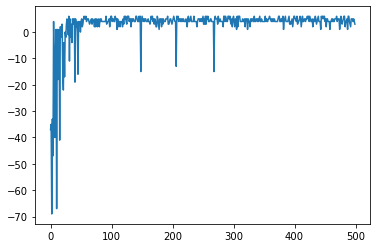

In [7]:
environment = GridWorld(exit_reward=10, pitfall_reward=-10, step_reward=-1)
agentQ = Agent(environment)

# Note the learn=True argument!
reward_per_episode = agentQ.play(trials=500,max_steps_per_episode=500)

# Simple learning curve
plt.plot(reward_per_episode)
agentQ.plot_environment()